In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge,Lasso, ElasticNet
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
import skopt.space.space
from sklearn.model_selection import KFold


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")


INPUT DATA

In [7]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [8]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [9]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


**RIDGE**

In [10]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)

ripartitions = [0.25,0.5,0.75]

results_ridge = []  


for ripartition in ripartitions:

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            result = {"Ripartition":None,
                       "Trial":None,
                         "alpha_bayesian":None,
                           #"alpha_evolutionary":None,
                             "bayesian_time":None,
                             #"evolutionary_time" :None,
                             "NRMSEPiqr_bayesian":None,
                              #"NRMSEPiqr_evolutionary":None,
                              "seed": None}
            

            print("Trial:",i+1)
                
            result["Ripartition"] = ripartition
            result["Trial"] = i +1
            result["seed"] = seeds[i]
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
            #sturges = int(1 + np.log(len(X_train)))    
            ridge_reg_pipeline = make_pipeline(StandardScaler(),Ridge())

            kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
            '''
            evolved_estimator = GASearchCV(estimator=ridge_reg_pipeline,
                                  cv=kf,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
            '''
            bayesian_estimator = BayesSearchCV(
                                ridge_reg_pipeline,
                                {'ridge__alpha': skopt.space.space.Real(1/100000,0.01,'log-uniform')},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
            '''
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            
            result["evolutionary_time"] = elapsed_time
            result["alpha_evolutionary"] = float(evolved_estimator.best_params_["ridge__alpha"])
            '''
            start_time = time.time()
            bayesian_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["bayesian_time"] = elapsed_time
            result["alpha_bayesian"] = float(bayesian_estimator.best_params_["ridge__alpha"])
    
           
            #result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

            result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
            print(result)
            results_ridge.append(result)




0.25 ripartition
Trial: 1
{'Ripartition': 0.25, 'Trial': 1, 'alpha_bayesian': 0.00034481242721433195, 'bayesian_time': 3.803175926208496, 'NRMSEPiqr_bayesian': 0.3369053279667596, 'seed': 47}
Trial: 2
{'Ripartition': 0.25, 'Trial': 2, 'alpha_bayesian': 0.0024299018791110348, 'bayesian_time': 2.4740025997161865, 'NRMSEPiqr_bayesian': 0.2928382721962111, 'seed': 59}
Trial: 3
{'Ripartition': 0.25, 'Trial': 3, 'alpha_bayesian': 0.0005702315170466723, 'bayesian_time': 2.857856512069702, 'NRMSEPiqr_bayesian': 0.3119917108184605, 'seed': 38}
Trial: 4
{'Ripartition': 0.25, 'Trial': 4, 'alpha_bayesian': 0.0003713244517597906, 'bayesian_time': 2.5829200744628906, 'NRMSEPiqr_bayesian': 0.29268051592957756, 'seed': 87}
Trial: 5
{'Ripartition': 0.25, 'Trial': 5, 'alpha_bayesian': 0.0010321260653823883, 'bayesian_time': 3.057724714279175, 'NRMSEPiqr_bayesian': 0.3095424227519705, 'seed': 49}
Trial: 6
{'Ripartition': 0.25, 'Trial': 6, 'alpha_bayesian': 0.004698427594716526, 'bayesian_time': 2.7203662

In [11]:


df = pd.DataFrame(results_ridge)
df.to_excel("Ridge_Bayes.xlsx")


In [12]:

ridge_alphas = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}

#Compute the mean for every ripartition
for trial in results_ridge:
    ridge_alphas[trial["Ripartition"]]+=trial["alpha_bayesian"]/trials



print(ridge_alphas)

{0.25: 0.0014292346039216288, 0.5: 0.001813283047883149, 0.75: 0.0034392628675535553}


╔════════════════╦══════════════════╦═════════════════╦════════════════════════════╦════════════╗
║   Test size(%) ║   Mean NRMSEPiqr ║   Var NRMSEPiqr ║   Mean Training Time (sec) ║      alpha ║
╠════════════════╬══════════════════╬═════════════════╬════════════════════════════╬════════════╣
║             25 ║         0.293582 ║     0.000277348 ║                  0.0562069 ║ 0.00142923 ║
║             50 ║         0.299761 ║     0.000114153 ║                  0.0489639 ║ 0.00181328 ║
║             75 ║         0.324165 ║     0.000155978 ║                  0.0199552 ║ 0.00343926 ║
╚════════════════╩══════════════════╩═════════════════╩════════════════════════════╩════════════╝


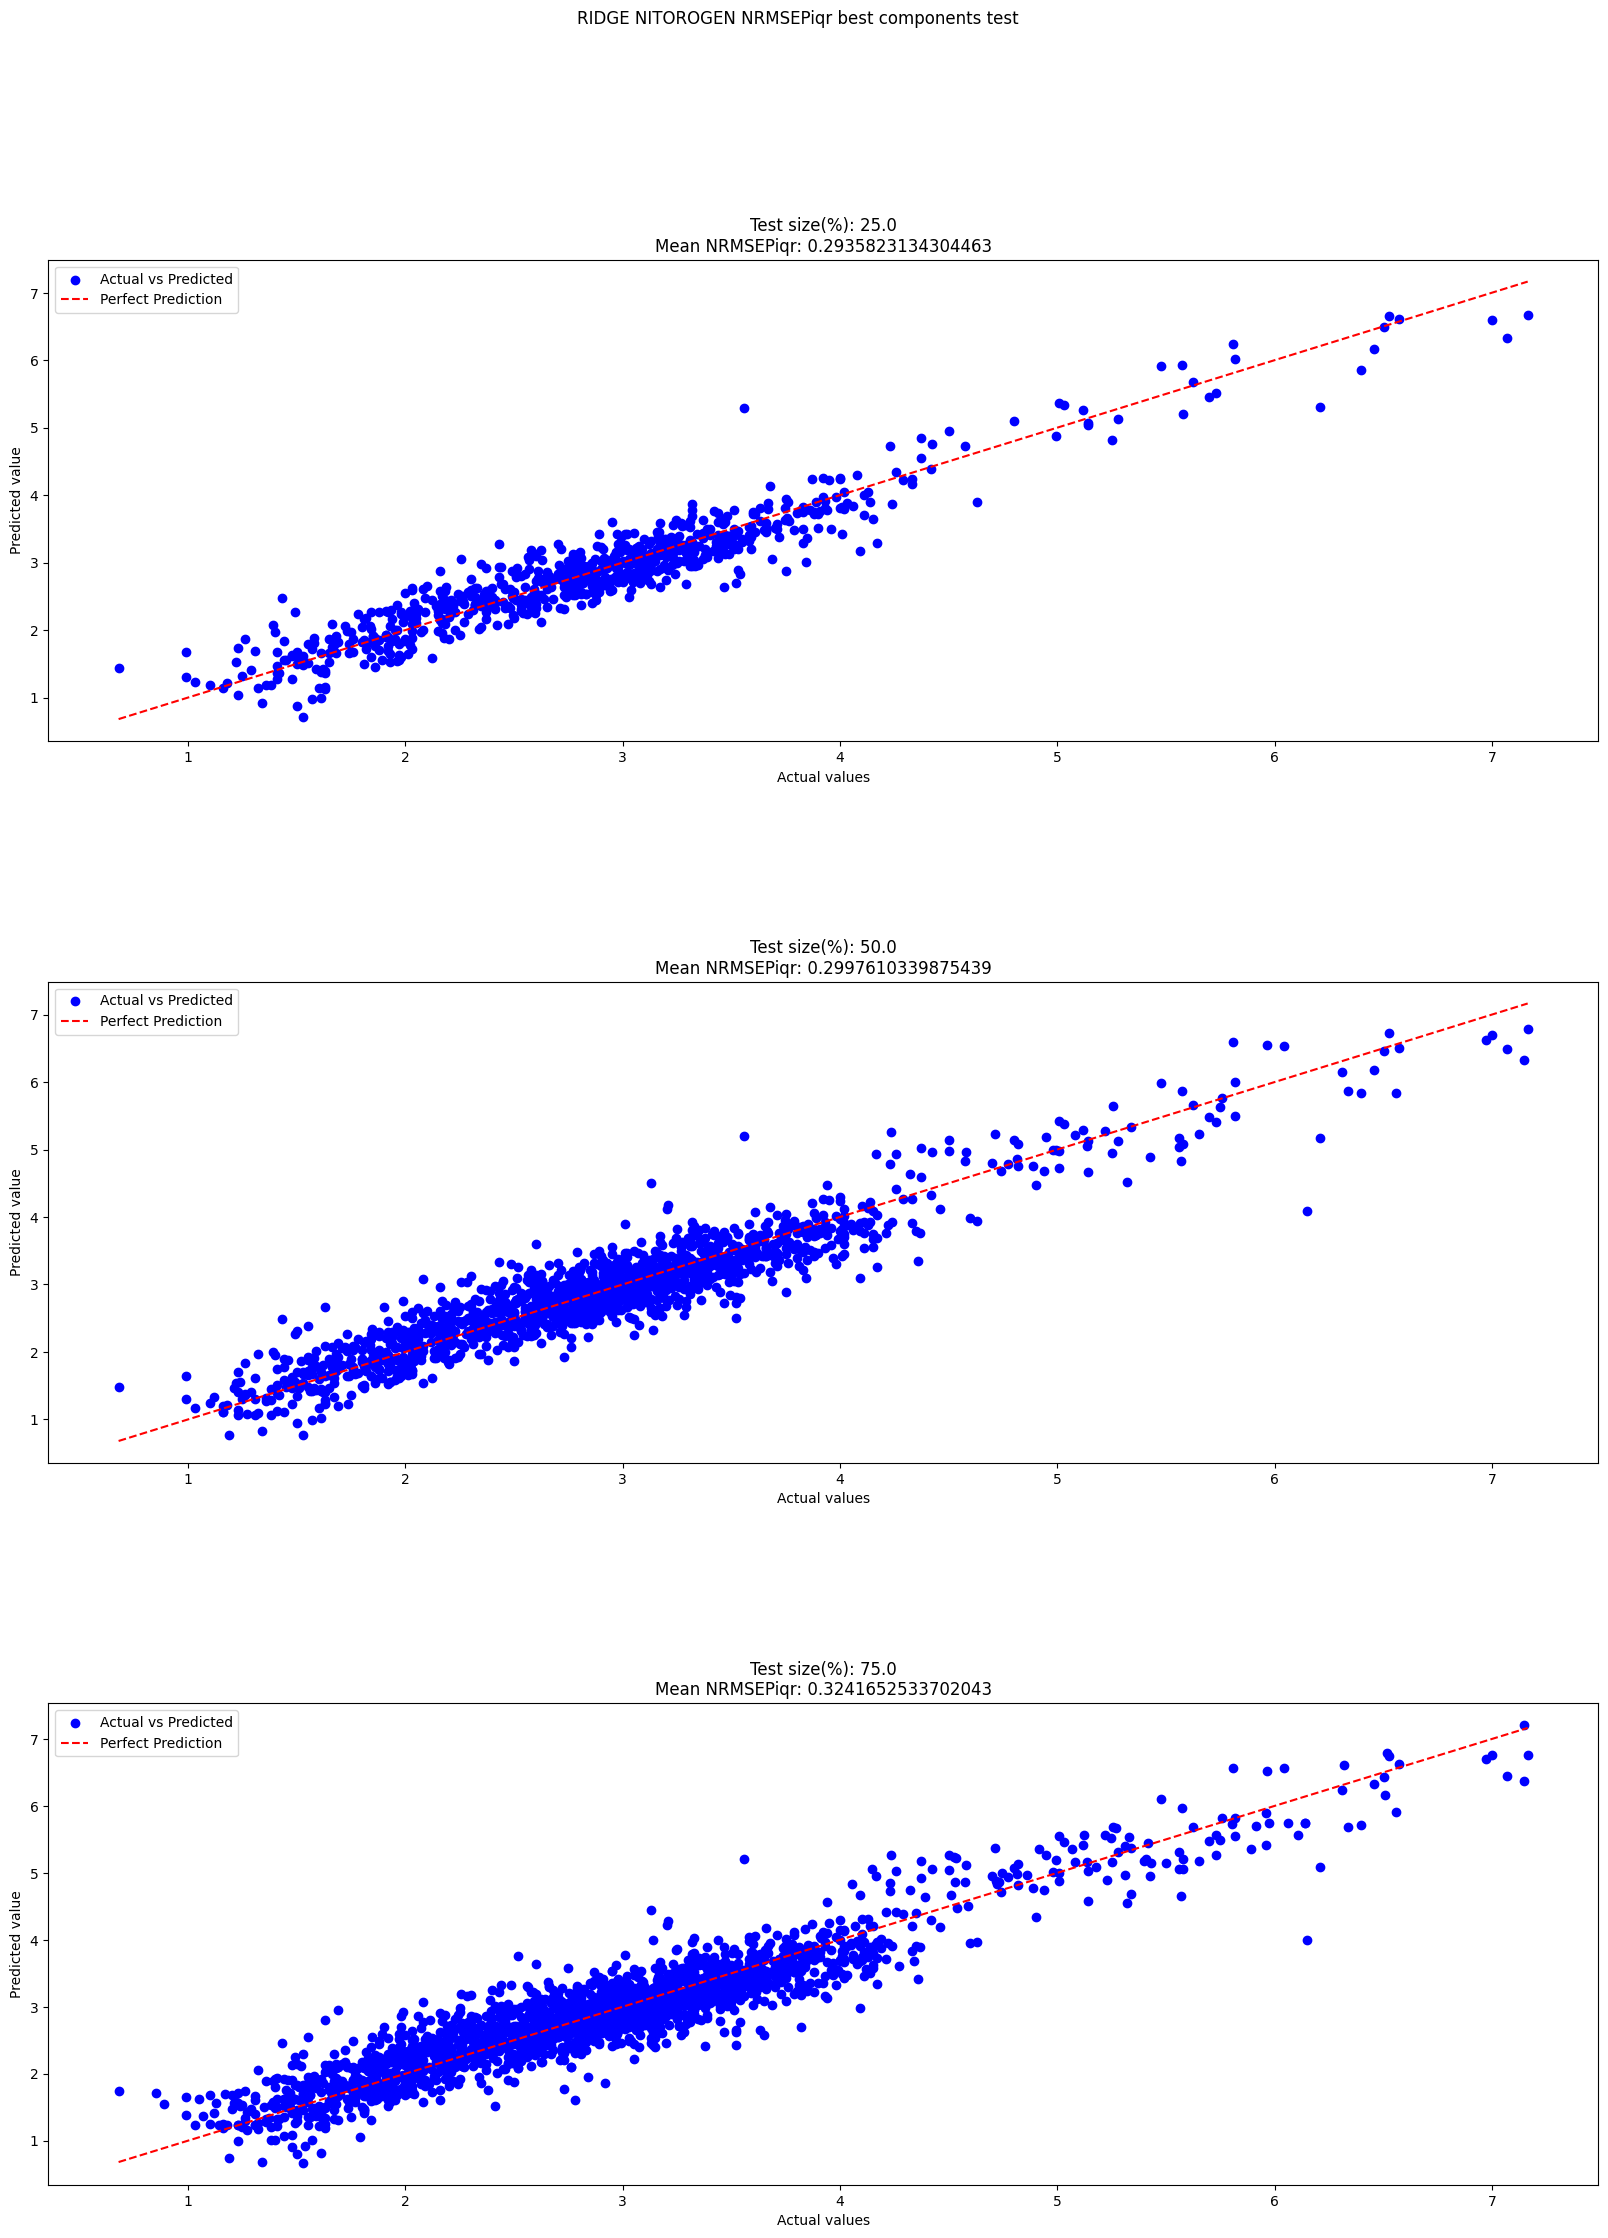

In [18]:


results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle(f'RIDGE NITOROGEN NRMSEPiqr best components test' + "\n")
axs = axs.flatten()
k = 0

trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)
    

results = []
for alpha, ripartition in zip(ridge_alphas.values(),ripartitions):
    
    NRMSE = []
    total_time = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        ridge = make_pipeline(StandardScaler(),Ridge(alpha=alpha))
            
        start_time = time.time()
        ridge.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
        # Make predictions using the testing set
        Y_pred_ridge = ridge.predict(X_test)

        
        NRMSE.append(NRMSEPiqr(Y_test, Y_pred_ridge))
        total_time+=elapsed_time
        

    results.append([str(ripartition *100 ),np.mean(NRMSE), np.var(NRMSE),
                       total_time/trials, alpha ])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_ridge, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" + "\n" + "Mean NRMSEPiqr: " + str(results[k][1]) )
    k += 1

    '''SHOW RESULTS'''

headers = ["Test size(%)", "Mean NRMSEPiqr", "Var NRMSEPiqr","Mean Training Time (sec)" ,"alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))


**LASSO**

In [14]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)

ripartitions = [0.25,0.5,0.75]

results_lasso = []  


for ripartition in ripartitions:

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            result = {"Ripartition":None,
                       "Trial":None,
                         "alpha_bayesian":None,
                           #"alpha_evolutionary":None,
                             "bayesian_time":None,
                             #"evolutionary_time" :None,
                             "NRMSEPiqr_bayesian":None,
                              #"NRMSEPiqr_evolutionary":None,
                              "seed": None}
            

            print("Trial:",i+1)
                
            result["Ripartition"] = ripartition
            result["Trial"] = i +1
            result["seed"] = seeds[i]
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'lasso__alpha': Continuous(1/100000,0.01)}
            #sturges = int(1 + np.log(len(X_train)))    
            lasso_reg_pipeline = make_pipeline(StandardScaler(),Lasso())

            kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
            
            '''
            evolved_estimator = GASearchCV(estimator=lasso_reg_pipeline,
                                  cv=kf,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
            '''
            
            bayesian_estimator = BayesSearchCV(
                                lasso_reg_pipeline,
                                {'lasso__alpha':  skopt.space.space.Real(1/100000,0.01,'log-uniform')},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
            
            '''
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
            '''

            #result["evolutionary_time"] = elapsed_time
            #result["alpha_evolutionary"] = float(evolved_estimator.best_params_["lasso__alpha"])
       
            start_time = time.time()
            bayesian_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["bayesian_time"] = elapsed_time
            result["alpha_bayesian"] = float(bayesian_estimator.best_params_["lasso__alpha"])
    
           
            #result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

            result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
            print(result)
            results_lasso.append(result)




0.25 ripartition
Trial: 1
{'Ripartition': 0.25, 'Trial': 1, 'alpha_bayesian': 0.0009636431574519377, 'bayesian_time': 8.315528392791748, 'NRMSEPiqr_bayesian': 0.5101197637525098, 'seed': 47}
Trial: 2
{'Ripartition': 0.25, 'Trial': 2, 'alpha_bayesian': 0.0008000387671491276, 'bayesian_time': 8.231104612350464, 'NRMSEPiqr_bayesian': 0.4753463451235034, 'seed': 59}
Trial: 3
{'Ripartition': 0.25, 'Trial': 3, 'alpha_bayesian': 0.0006264360308471433, 'bayesian_time': 8.56126594543457, 'NRMSEPiqr_bayesian': 0.4732602544714244, 'seed': 38}
Trial: 4
{'Ripartition': 0.25, 'Trial': 4, 'alpha_bayesian': 0.0006881274951227802, 'bayesian_time': 8.173617124557495, 'NRMSEPiqr_bayesian': 0.4419028118868511, 'seed': 87}
Trial: 5
{'Ripartition': 0.25, 'Trial': 5, 'alpha_bayesian': 0.0007976949343821697, 'bayesian_time': 8.434895277023315, 'NRMSEPiqr_bayesian': 0.4830155695713868, 'seed': 49}
Trial: 6
{'Ripartition': 0.25, 'Trial': 6, 'alpha_bayesian': 0.0007824977165852127, 'bayesian_time': 8.30829405784

KeyboardInterrupt: 

In [30]:
from collections import Counter

df = pd.DataFrame(results_lasso)
df.to_excel("Lasso_Bayes.xlsx")


In [29]:

lasso_alphas = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}

#Compute the mean for every ripartition
for trial in results_lasso:
    lasso_alphas[trial["Ripartition"]]+=trial["alpha_bayesian"]/trials



print(lasso_alphas)

{0.25: 0.0007550138089340841, 0.5: 0.0007418934244312225, 0.75: 0.0007075351516145146}


In [ ]:


# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle(f'LASSO NITOROGEN NRMSEPiqr best components test' + "\n")
axs = axs.flatten()
k = 0

trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)
    

results = []
for alpha, ripartition in zip (lasso_alphas.values(),ripartitions):
    
    NRMSE = []
    total_time = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        lasso = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
            
        start_time = time.time()
        lasso.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
        # Make predictions using the testing set
        Y_pred_lasso = lasso.predict(X_test)

        
        NRMSE.append(NRMSEPiqr(Y_test, Y_pred_lasso))
        total_time+=elapsed_time
        

    results.append([str(ripartition *100 ),np.mean(NRMSE), np.var(NRMSE),
                       total_time/trials, alpha ])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_lasso, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}"+ "\n" + "Mean NRMSEPiqr: " + str(results[k][1]) )
    k += 1

    '''SHOW RESULTS'''

headers = ["Test size(%)", "Mean NRMSEPiqr", "Var NRMSEPiqr","Mean Training Time (sec)" ,"alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))


**ELASTIC NET**

In [40]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)

ripartitions = [0.25,0.5,0.75]

results_elastic = []  


for ripartition in ripartitions:

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            result = {"Ripartition":None,
                       "Trial":None,
                         "alpha_bayesian":None,
                           #"alpha_evolutionary":None,
                             "bayesian_time":None,
                             #"evolutionary_time" :None,
                             "NRMSEPiqr_bayesian":None,
                             "l1_ratio_bayesian": None,
                             # "NRMSEPiqr_evolutionary":None,
                              "seed": None}
            

            print("Trial:",i+1)
                
            result["Ripartition"] = ripartition
            result["Trial"] = i +1
            result["seed"] = seeds[i]
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'elasticnet__alpha': Continuous(1/100000,0.01)}
            #sturges = int(1 + np.log(len(X_train)))    
            elastic_reg_pipeline = make_pipeline(StandardScaler(),ElasticNet())

            kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
            '''
            evolved_estimator = GASearchCV(estimator=elastic_reg_pipeline,
                                  cv=kf,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10)
            '''
            bayesian_estimator = BayesSearchCV(
                                elastic_reg_pipeline,
                                {'elasticnet__alpha':  skopt.space.space.Real(1/100000,0.01,'log-uniform'),
                                 'elasticnet__l1_ratio': skopt.space.space.Real(0,1,'uniform')},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
            '''
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["evolutionary_time"] = elapsed_time
            result["alpha_evolutionary"] = float(evolved_estimator.best_params_["elasticnet__alpha"])
            '''

            start_time = time.time()
            bayesian_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds

            result["bayesian_time"] = elapsed_time
            result["alpha_bayesian"] = float(bayesian_estimator.best_params_["elasticnet__alpha"])
            result["l1_ratio_bayesian"] = float(bayesian_estimator.best_params_["elasticnet__l1_ratio"])
    
           
            #result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

            result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
            print(result)
            results_elastic.append(result)




0.25 ripartition
Trial: 1
{'Ripartition': 0.25, 'Trial': 1, 'alpha_bayesian': 0.00496653142900246, 'bayesian_time': 9.087973594665527, 'NRMSEPiqr_bayesian': 0.4860233133043454, 'l1_ratio_bayesian': 0.07688130416789653, 'seed': 47}
Trial: 2


KeyboardInterrupt: 

In [31]:
from collections import Counter

df = pd.DataFrame(results_elastic)
df.to_excel("Elastic_Bayes.xlsx")



In [33]:
elastic_alphas = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}
elastic_ratio = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}

#Compute the mean for every ripartition
for trial in results_elastic:
    elastic_alphas[trial["Ripartition"]]+=trial["alpha_bayesian"]/trials
    elastic_ratio[trial["Ripartition"]]+=trial["l1_ratio_bayesian"]/trials


print(elastic_alphas)
print(elastic_ratio)

{0.25: 0.0013384919254866318, 0.5: 0.0013893736706127072, 0.75: 0.001388904484900191}


In [ ]:

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle(f'ELASTIC NET NITOROGEN NRMSEPiqr best components test' + "\n")
axs = axs.flatten()
k = 0

trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials)
    

results = []
ripartisions = [0.25]
for alpha, l1_ratio, ripartition in zip (elastic_alphas.values(), elastic_ratio.values(),ripartisions):
    
    NRMSE = []
    total_time = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        elastic = make_pipeline(StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
            
        start_time = time.time()
        elastic.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
        # Make predictions using the testing set
        Y_pred_elastic = elastic.predict(X_test)

        
        NRMSE.append(NRMSEPiqr(Y_test, Y_pred_elastic))
        total_time+=elapsed_time
        

    results.append([str(ripartition *100 ),np.mean(NRMSE), np.var(NRMSE),
                       total_time/trials, alpha, l1_ratio ])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_elastic, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" + "\n" + "Mean NRMSEPiqr: " + str(results[k][1]) )
    k += 1

    '''SHOW RESULTS'''

headers = ["Test size(%)", "Mean NRMSEPiqr", "Var NRMSEPiqr","Mean Training Time (sec)" ,"alpha", "l1_ratio"]
print(tabulate(results, headers,  tablefmt="double_outline"))
